In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [2]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-8, 1e-8],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.5,
    'bisection_tol': 1e-12,
}

In [3]:
def integrate_one_cycle(sim, configs):
    time_step = configs['init_time_step']
    bisection_tol = configs['bisection_tol']
    target_mean_anomaly = configs['target_mean_anomaly']
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_sin_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_sin_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on sin M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < 1e-8:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [4]:
def init_simulation(theta, configs):
    inner_period = configs['inner_period']
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=configs['planet_mass'][0], P=inner_period, e=init_e[0])
    sim.add(m=configs['planet_mass'][1], P=inner_period*configs['kappa'], pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta, configs):
    init_theta = theta
    init_sim = init_simulation(init_theta, configs)

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim, configs)
    final_sim.move_to_hel()
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    # print(init_theta, final_theta)
    # print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    # print(diff)
    return diff

    # return theta_diff

[-9.87527392e+00 -8.00000000e-01 -2.65665755e-02  5.80650429e-03] 0.0857132394035228
[-8.99547268e+00 -9.29634194e-01 -2.76534150e-02  6.48688913e-03] 0.08571933467671336
[-7.93782986e+00 -8.56365819e-01 -3.31752215e-02  6.22738428e-03] 0.08571638588633301
[-6.90666974 -0.80000115 -0.358035   -0.05044709] 0.08554255143591388
[-5.90776003 -0.80000869 -0.3569688  -0.0513616 ] 0.08554192940428146
[-5.07980539 -0.8711519  -0.81656504 -0.65350858] 0.08546878693760607
[-4.07068336 -0.80001546 -0.88593848 -0.7711824 ] 0.08538614305278588
[-2.84658654 -0.8        -0.38373576 -0.49695432] 0.08426107915231927
[-1.81887508 -0.8        -0.44398601 -0.60854318] 0.07253011163666684
[-1.81887508 -0.8        -0.44398601 -0.60854318]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


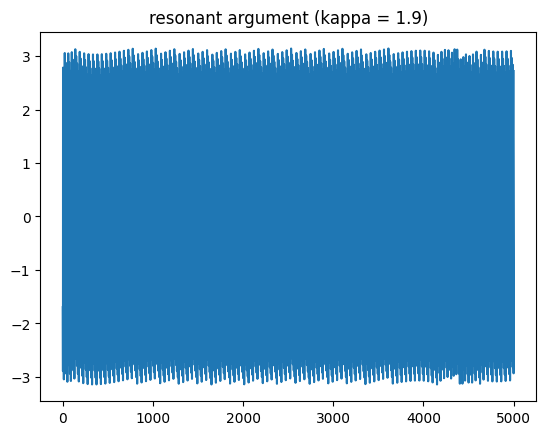

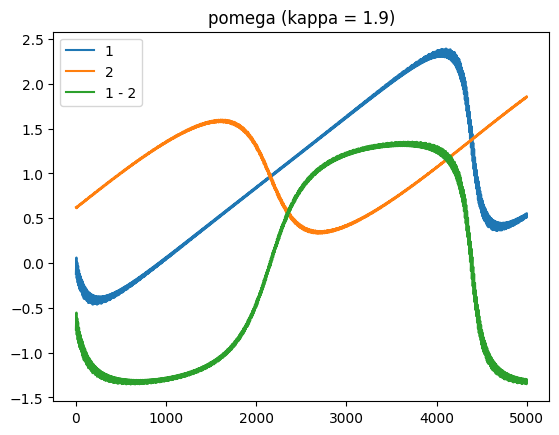

[-9.74964883e+00 -8.00000000e-01  3.94455454e-03  9.74609684e-04] 0.053985620220740195
[-8.83738536e+00 -8.89329736e-01  4.13682044e-03  9.94130094e-04] 0.053989132883061446
[-7.88194986e+00 -9.48635511e-01  4.27239203e-03  1.00613052e-03] 0.05398939100222358
[-4.07107234e+00 -8.20701125e+00  2.79451487e-05 -2.07188536e-03] 0.0381188229889161
[-3.74832564e+00 -7.20656459e+00  2.81770312e-05 -2.24429334e-03] 0.038182034867159424
[-3.25794739e+00 -6.20807776e+00  3.10093176e-05 -2.39367230e-03] 0.03839171410721733
[-0.80001355 -4.19805738 -0.0195989  -0.98923889] 0.03425501132083415
[-0.80253306 -3.03526115 -0.53930794 -1.72974877] 0.03408534226239247
[-0.8        -2.00398841 -0.648032   -1.84593312] 0.03236308331272881
[-0.8        -2.00398841 -0.648032   -1.84593312]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.92), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection

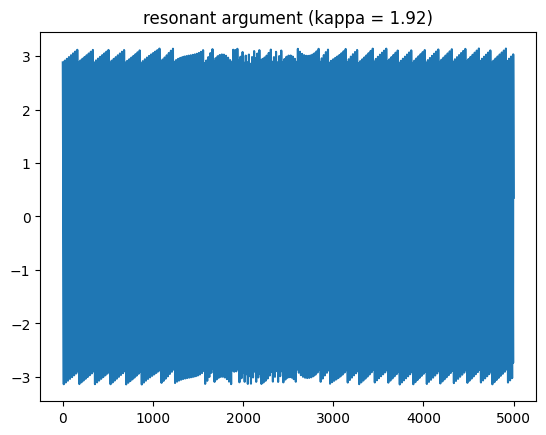

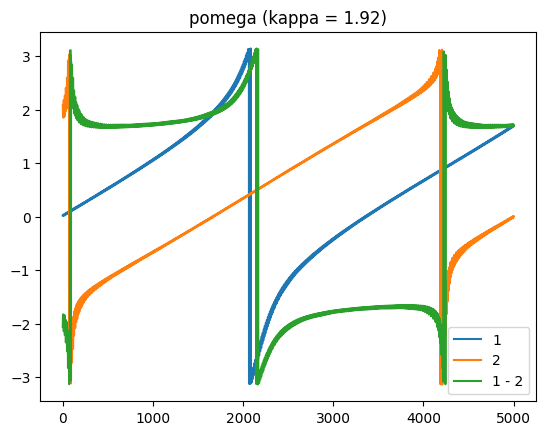

[-10.         -10.           0.62343857   0.3460446 ] 0.0276325903565939
[-10.         -10.          -0.72222734  -1.79073544] 0.08295607796891272
[-10.         -10.          -1.61762113  -2.98712989] 1.4619214416994517
[-10.         -10.          -0.39129942  -2.44293204] 8.707722243852638
[-10.         -10.          -0.02875822  -2.28252289] 17.47758624843212
[-10.         -10.          -0.0278014   -2.30854428] 30.713812953108658
[-10.         -10.          -0.02695581  -2.31083211] 47.98870562252397
[-1.00000000e+01 -1.00000000e+01  3.28876917e-03 -2.28621058e+00] 69.25707609690542
[-1.00000000e+01 -1.00000000e+01  3.59568435e-03 -2.33760765e+00] 94.44486448165944
[-1.00000000e+01 -1.00000000e+01  3.59568435e-03 -2.33760765e+00]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.94), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


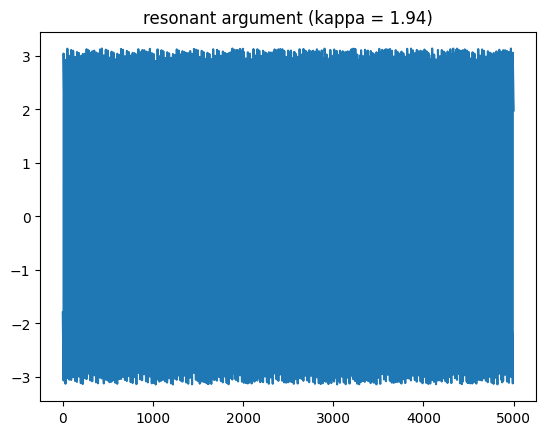

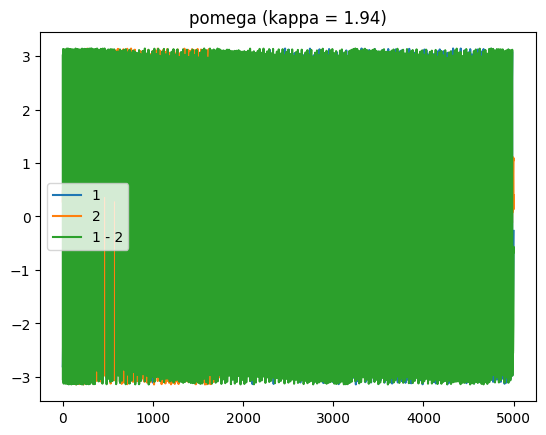

[-9.58878418 -9.97550968 -0.31126978 -0.82216531] 0.010903231066128016
[-1.70233871 -9.25221225 -0.81074822 -1.87754995] 0.008221196537274149
[-1.7726616  -8.26092317 -0.84444635 -1.92152109] 0.00822123891468863
[-1.84854712 -7.27010417 -0.86487743 -1.94517279] 0.00822122005725501
[-1.8865841  -6.26610499 -0.95678443 -2.10128925] 0.008220925993869213
[-5.41084404 -5.92731721 -1.43524914 -3.02548384] 1.7596780574362287e-10
[-4.40419848 -4.9272671  -1.51653104 -3.13312715] 7.374875393680865e-05
[-3.41073406 -3.92499665 -1.43560086 -3.02586922] 2.6666557912010162e-11
[-0.80000002 -2.52281416 -3.14159265 -3.07752858] 0.008224330287841218
[-0.80000002 -2.52281416 -3.14159265 -3.07752858]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.96), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


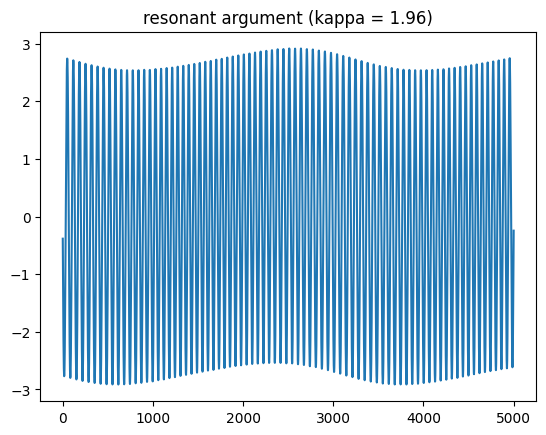

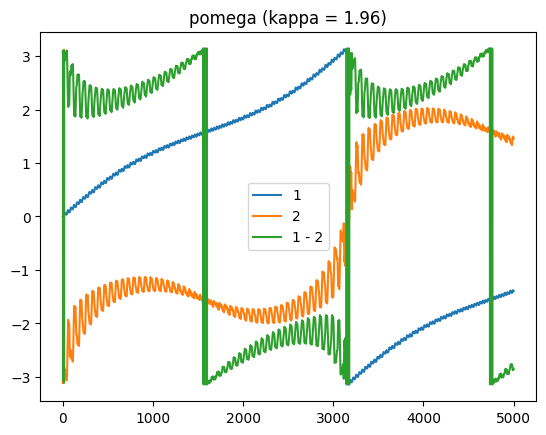

[ -7.48668205 -10.          -0.0120574   -0.02646414] 0.0021911610904928815
[ -1.17294406 -10.          -0.01898863  -0.02793339] 0.0020399667595583323
[-1.10159209e+00 -1.00000000e+01 -4.10528927e-02 -9.00901934e-03] 0.0020058061657392207
[-1.09475485e+00 -1.00000000e+01 -4.10618502e-02 -9.32601684e-03] 0.002010694255598259
[-1.09405595e+00 -1.00000000e+01 -4.14952802e-02 -9.77458161e-03] 0.0020211845445298514
[-1.09397898e+00 -1.00000000e+01 -4.15076536e-02 -9.77771643e-03] 0.002082799968401353
[-1.09394865e+00 -1.00000000e+01 -4.15044618e-02 -9.76111838e-03] 0.002141073020612317
[-1.09371118e+00 -1.00000000e+01 -4.15599768e-02 -9.73297020e-03] 0.002048372681959143
[-1.09134407e+00 -1.00000000e+01 -4.24285657e-02 -9.77006389e-03] 0.0021503254648946512
[-1.09134407e+00 -1.00000000e+01 -4.24285657e-02 -9.77006389e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.98), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 1

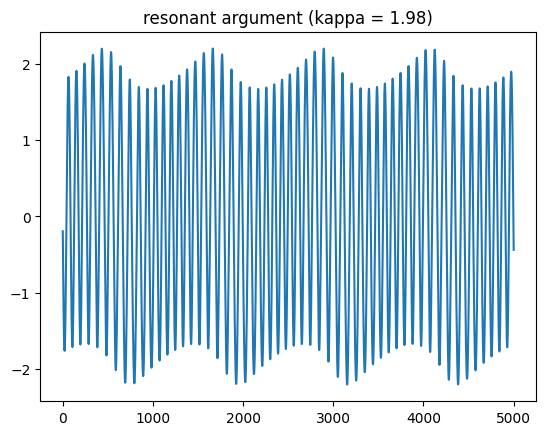

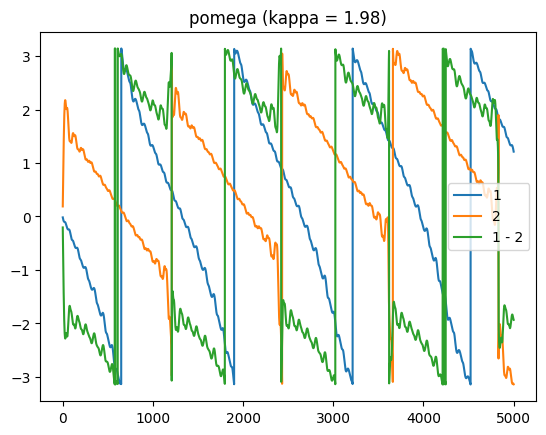

[-1.5 -1.5  0.   0. ] 4.4570641144987167e-29
[-1.5375 -1.5     0.      0.    ] 1.1537090738857298e-29
[-1.5375e+00 -1.5000e+00  0.0000e+00  2.5000e-04] 1.916374761679158e-15
[-8.00000000e-01 -1.76320741e+00  2.03492477e-03  2.79785734e-04] 3.328981566464208e-19
[-8.00000000e-01 -1.76730136e+00  2.00849259e-03  2.90944418e-04] 1.7803719865339006e-17
[-8.00000000e-01 -1.76712325e+00 -7.60568158e-04  5.49051500e-04] 1.2787777614990673e-15
[-8.00000000e-01 -1.76708923e+00 -7.01059750e-04  5.46413558e-04] 1.4132550970382002e-13
[-8.00000000e-01 -1.76750919e+00 -6.39460453e-04  5.73018332e-04] 1.4065118496021545e-11
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04] 1.2681751177486516e-09
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol':

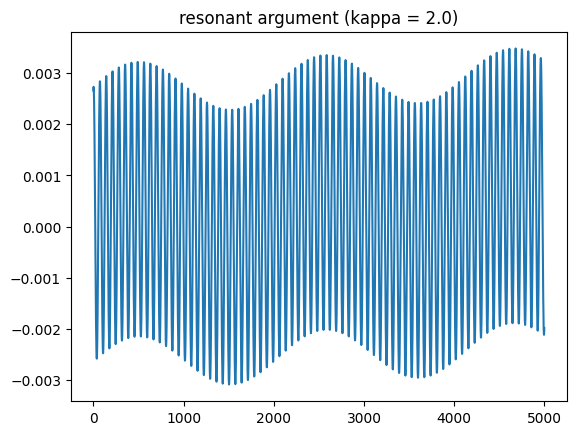

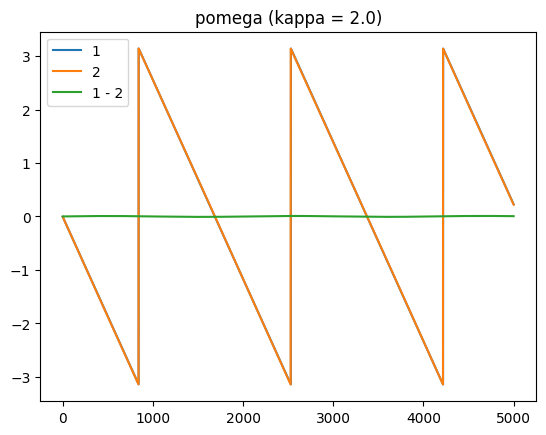

[ -0.8        -10.           0.02573737   0.04543334] 0.00304106202491126
[ -0.87833654 -10.           0.02450265   0.04712843] 0.001972675814169812
[ -0.93166859 -10.           0.05339548   0.02249198] 0.0019318387542999874
[ -0.93686485 -10.           0.05384157   0.02276894] 0.0019324815735239226
[ -0.93739172 -10.           0.05436016   0.02327389] 0.0019427214278365209
[ -0.93743902 -10.           0.05437367   0.02327394] 0.001960133529161868
[ -0.93742949 -10.           0.05437516   0.02327449] 0.0020181495497781183
[ -0.93728112 -10.           0.05423241   0.02317736] 0.0019414229030988845
[ -0.935794   -10.           0.0542646    0.02365265] 0.001931031412739868
[ -0.935794   -10.           0.0542646    0.02365265]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.02), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


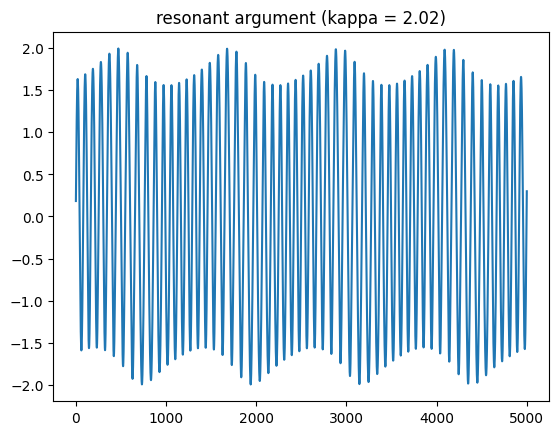

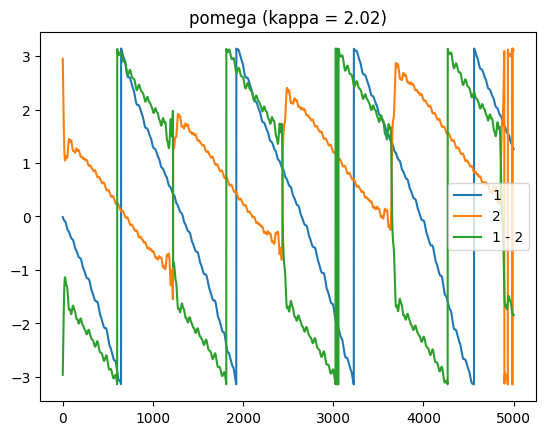

[-8.0000000e-01 -1.0000000e+01  5.4443441e-02 -5.5799449e-03] 0.01404584806048886
[-8.00000000e-01 -1.00000000e+01  5.81119931e-02 -5.45679378e-03] 0.007976802047297973
[-8.70205671e-01 -1.00000000e+01  6.13363087e-02 -5.26985527e-03] 0.007449240319725391
[-8.80141426e-01 -1.00000000e+01  5.56265786e-02 -5.72007650e-03] 0.007569982350991898
[-8.81132517e-01 -1.00000000e+01  5.56752587e-02 -5.89427966e-03] 0.007579070284321927
[-8.81231561e-01 -1.00000000e+01  5.55042948e-02 -6.09209707e-03] 0.007629532906133196
[-8.81228274e-01 -1.00000000e+01  5.55279631e-02 -6.06759361e-03] 0.007568904751186514
[-8.81107907e-01 -1.00000000e+01  5.51725363e-02 -6.38728248e-03] 0.007614799964856596
[-8.79895220e-01 -1.00000000e+01  5.44549768e-02 -6.74906647e-03] 0.007548010938139545
[-8.79895220e-01 -1.00000000e+01  5.44549768e-02 -6.74906647e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.04), 'inner_period': 6.283185307179586, 'C': [], 'target_me

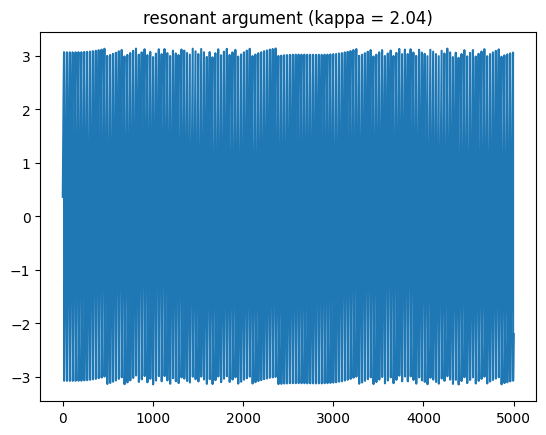

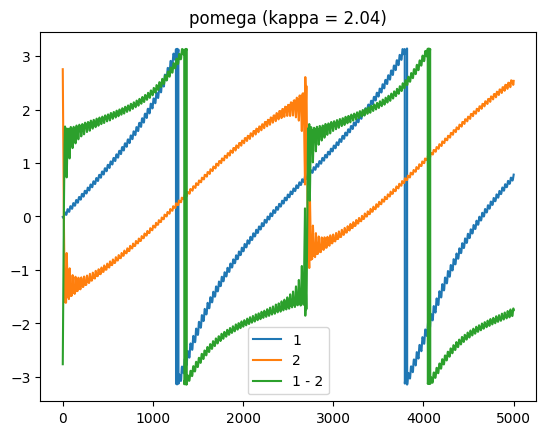

[ -0.8        -10.           0.02187656  -0.0843558 ] 0.03275715361858079
[ -0.8        -10.           0.02188779  -0.08143919] 0.026927948201958124
[ -0.8        -10.           1.04333417   0.95184398] 0.0215072756644645
[ -0.83248136 -10.           1.00293293   0.9149509 ] 0.01674570922046737
[ -0.83327563 -10.           1.00548328   0.91430355] 0.016767703825004927
[ -0.83336356 -10.           1.00582011   0.91434613] 0.016926627829174062
[ -0.83335282 -10.           1.00582657   0.9143444 ] 0.40721799235331346
[ -0.83326517 -10.           1.00311555   0.91164635] 0.01675811149296958
[ -0.83225109 -10.           1.01132984   0.92015604] 0.016658119318650823
[ -0.83225109 -10.           1.01132984   0.92015604]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.06), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


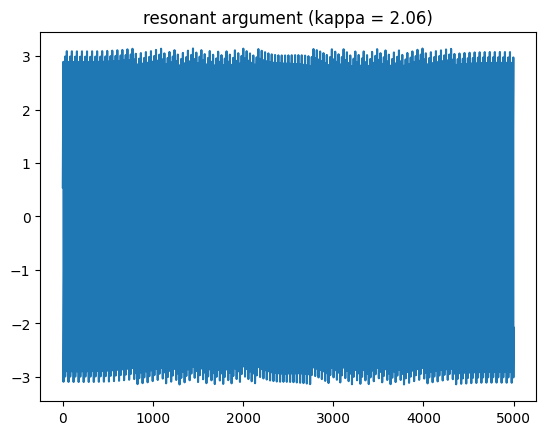

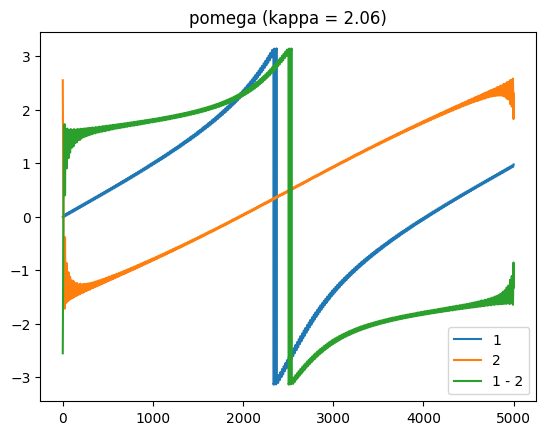

[-8.00000000e-01 -1.50029232e+00  1.17471135e-03  1.01762870e-04] 0.05840002617422928
[-8.00000000e-01 -1.50741047e+00  1.18430008e-03  1.03533049e-04] 0.05840002634809076
[-0.8        -0.8         0.09957814  1.30584581] 0.05840001961054923
[-0.8        -7.23530737 -0.29451909  1.49687504] 0.029200014597606856
[-0.86599806 -6.30160338 -0.30985264  1.50302802] 0.029200048688126597
[-0.95293579 -5.382099   -0.31966965  1.52487197] 0.029200402847159992
[-1.06729678 -4.47375383 -0.33518788  1.55042351] 0.029204519021309938
[-0.80491282 -3.23403661 -0.32104995  1.46023013] 0.02923599331459851
[-0.80000734 -2.20889879 -0.39755468  1.33996876] 0.02956447351280326
[-0.80000734 -2.20889879 -0.39755468  1.33996876]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.08), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


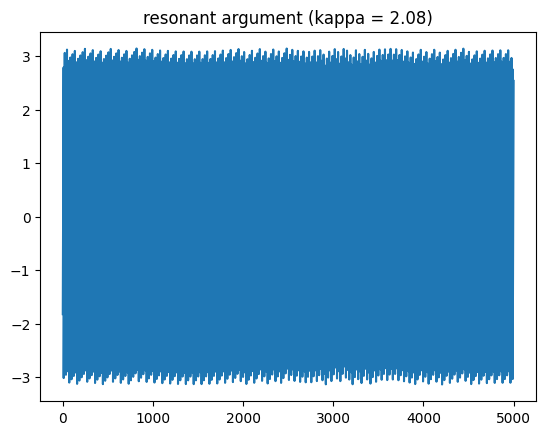

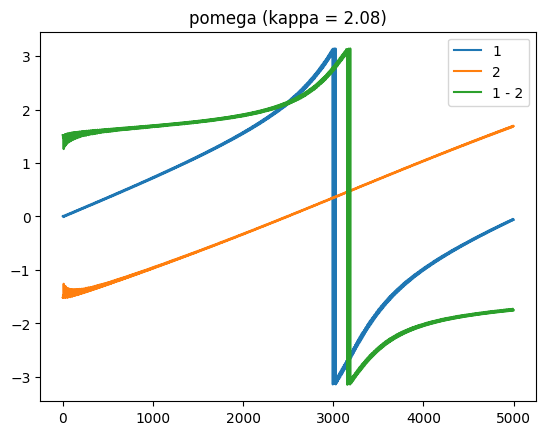

[-8.00000000e-01 -1.27958159e+00 -2.30415142e-04 -1.72044170e-03] 0.0895202214900331
[-0.8        -0.8        -0.0540908   1.07966024] 0.08952022110351388
[-0.8        -8.51641533  0.28682601  2.28851555] 0.044760053077503956
[-0.8        -2.17409139 -0.25664512  3.14159265] 0.08952020933918589
[-1.30053869 -7.17443596 -0.40325791  2.95390372] 0.04475992563162347
[-0.88214268 -6.08535583 -2.05411005  1.20277163] 0.044759547900169616
[-1.14272323 -5.98190074 -1.50457594  1.55028593] 0.044747491584138196
[-1.1484094  -5.94309453 -1.47191678  1.52724129] 0.04463359873985069
[-1.77866447 -3.11548668 -0.34950107  3.00673236] 0.04093262231293564
[-1.77866447 -3.11548668 -0.34950107  3.00673236]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.1), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


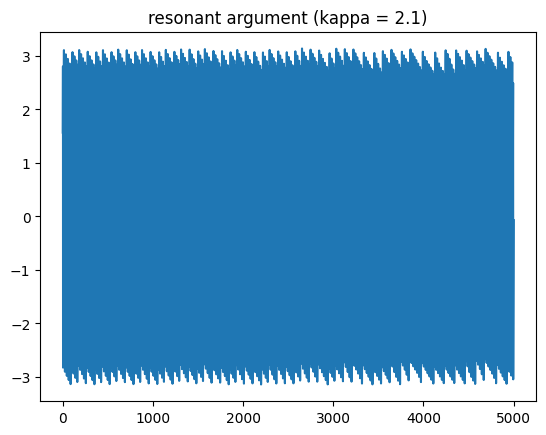

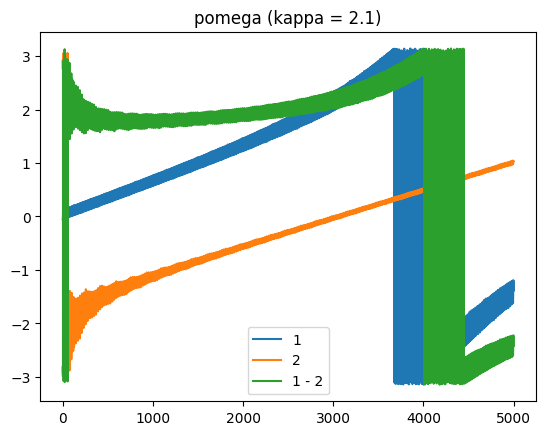

In [5]:
# Mass Continuation then Kappa

mass_cands = 10 ** np.arange(-12., -3., 1.)
kappa_cands = np.linspace(1.90, 2.10, 11)

bounds = [(-10, -0.8), (-10, -0.8), (-np.pi, np.pi), (-np.pi, np.pi)]

for j, kappa in enumerate(kappa_cands):
    init_theta = [-1.5, -1.5, 0, 0]
    
    for i, m in enumerate(mass_cands):
        m_configs = default_configs.copy()
        m_configs['planet_mass'] = [m, m]
        m_configs['kappa'] = kappa
    
        res = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,))
        init_theta = res.x
        print(res.x, res.fun)
    
    print(res.x)

    marks = np.arange(0, 5001, 1)

    sim = init_simulation(res.x, m_configs)
    _, target_time, _, _ = integrate_one_cycle(sim, m_configs)
    print(m_configs)
    
    angle_hist = np.zeros(len(marks))
    pomega_1_hist = np.zeros(len(marks))
    pomega_2_hist = np.zeros(len(marks))
    
    for i, _ in enumerate(marks):
        sim.integrate(sim.t + target_time)
        sim.t = 0
        sim.move_to_hel()
        
        angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega
    
        pomega_1_hist[i] = sim.particles[1].pomega
        pomega_2_hist[i] = sim.particles[2].pomega
    
        # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

    plt.plot(wrap_angles(angle_hist))
    plt.title(f'resonant argument (kappa = {m_configs['kappa']})')
    plt.show()
    plt.plot(wrap_angles(pomega_1_hist), label='1')
    plt.plot(wrap_angles(pomega_2_hist), label='2')
    plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
    plt.legend()
    plt.title(f'pomega (kappa = {m_configs['kappa']})')
    plt.show()
        